<a href="https://colab.research.google.com/github/SamuelWanjiru/Stock-market-forecasting/blob/main/Stock_market_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='blue'>Stock market forecasting using Time Series analysis ⏲ </font>**

### **<font color='red'>Brief overview of a stock market**

✅ The stock market is a market that enables the seamless exchange of buying and selling of company stocks. <br />
✅ Every Stock Exchange has its own Stock Index value. 

✅The index is the average value that is calculated by combining several stocks. 

✅This helps in representing the entire stock market and predicting the market’s movement over time. 

✅The stock market can have a huge impact on people and the country’s economy as a whole. 

✅Therefore, predicting the stock trends in an efficient manner can minimize the risk of loss and maximize profit.

Get more information about stock markets [here](https://en.wikipedia.org/wiki/Stock_market)

**Here in this notebook we will forecast the stock price of ARCH CAPITAL GROUP using ARIMA model**

**What is ARIMA?**

Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.

ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction. Read more [here](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp#:~:text=An%20autoregressive%20integrated%20moving%20average%2C%20or%20ARIMA%2C%20is%20a%20statistical,values%20based%20on%20past%20values.)

## **Connecting/mounting the google drive**

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Importing the relevant data analysis libraries**

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### **Loading the dataset from google drive**

Here, we parse the date variable from an object to a datetime variable.

We also deal with missing values here by replacing any NA value with 0.

The date column is also set as the index column and variables set to coma separated format.

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv(r'/content/gdrive/My Drive/KAGGLE PROJECTS/Stock market forecasting/Data/acgl.us.txt',
                         sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

### **Understanding the data**

In [6]:
# Displaying the 1st 5 observations of the stock dataset
stock_data.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.583,13.693,13.430,13.693,156240,0
2005-02-28,13.697,13.827,13.540,13.827,370509,0
2005-03-01,13.780,13.913,13.720,13.760,224484,0
2005-03-02,13.717,13.823,13.667,13.810,286431,0
2005-03-03,13.783,13.783,13.587,13.630,193824,0


**Getting the data description**

In [7]:
stock_data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3201.000000,3201.000000,3201.000000,3201.000000,3.201000e+03,3201.0
mean,41.800246,42.127681,41.465992,41.826403,7.830475e+05,0.0
std,23.728163,23.847994,23.593876,23.730770,6.482674e+05,0.0
min,13.170000,13.270000,11.010000,13.180000,5.236800e+04,0.0
25%,22.653000,22.907000,22.370000,22.643000,3.591570e+05,0.0
50%,33.100000,33.430000,32.800000,33.150000,5.823510e+05,0.0
75%,57.550000,57.890000,57.240000,57.550000,1.033461e+06,0.0
max,102.450000,102.600000,101.840000,102.380000,1.388090e+07,0.0


### **Data Visualizations**

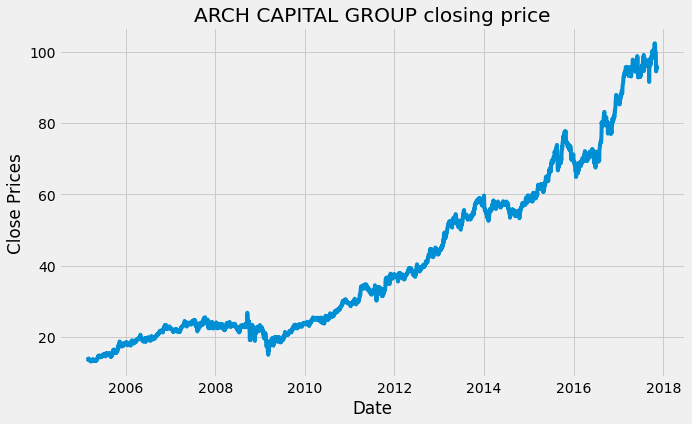

In [8]:
#plot close price

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

### **Data distribution**

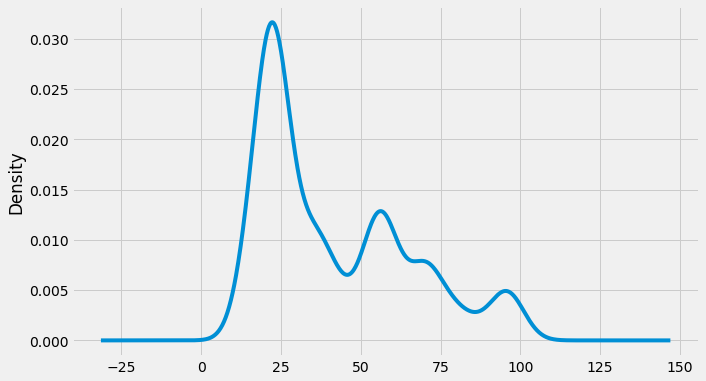

In [9]:
stock_data.Close.plot(kind='kde')
plt.show();

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:


*   Level: The average value in the series.
*   Trend: The increasing or decreasing value in the series.
*   Seasonality: The repeating short-term cycle in the series.
*   Noise: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

**Null Hypothesis:** The series has a unit root (value of a =1)

**Alternate Hypothesis:** The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

**So let's check for stationarity**

In [10]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    


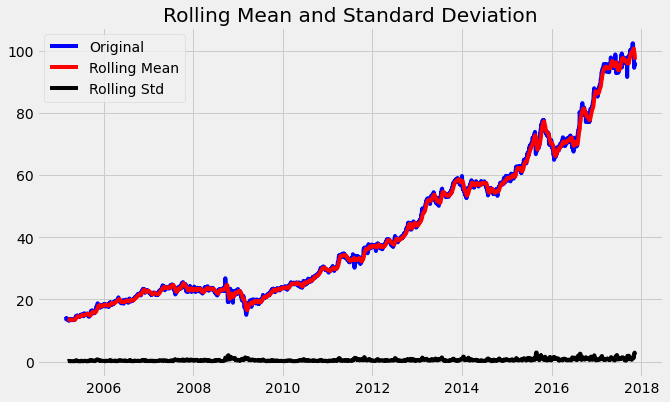

Results of dickey fuller test
Test Statistics                   1.374899
p-value                           0.996997
No. of lags used                  5.000000
Number of observations used    3195.000000
critical value (1%)              -3.432398
critical value (5%)              -2.862445
critical value (10%)             -2.567252
dtype: float64


In [11]:
test_stationarity(stock_data.Close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.


We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

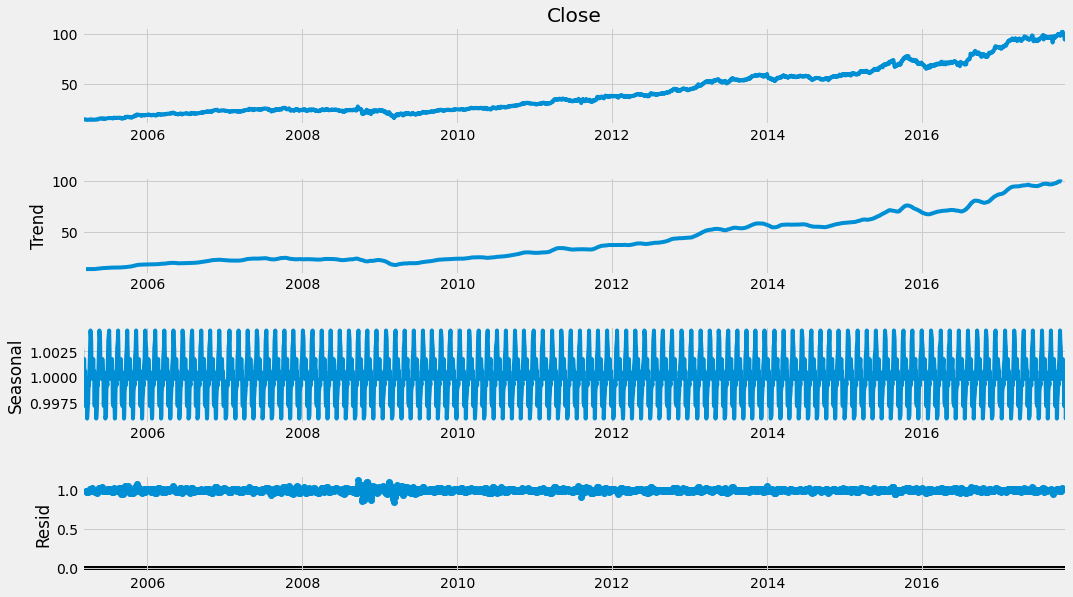

In [12]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.

result = seasonal_decompose(stock_data.Close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

plt.show();

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

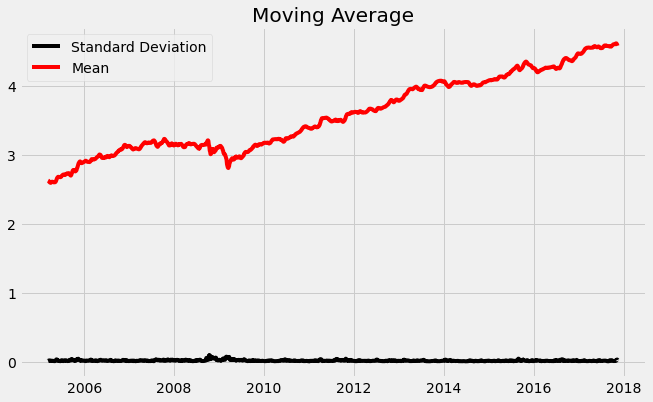

In [13]:
#if not stationary then eliminate trend
#Eliminate trend

rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_data.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show();

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

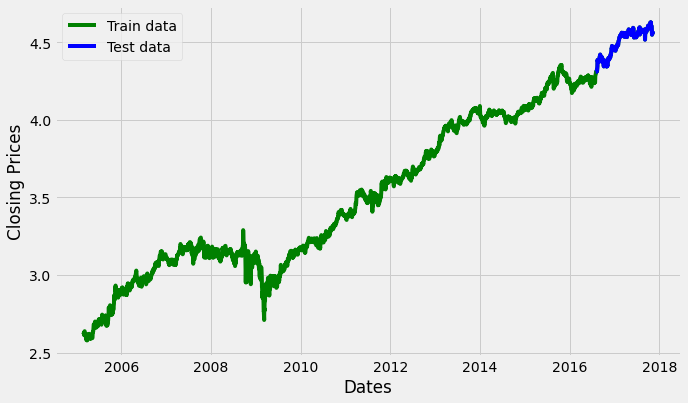

In [15]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

**Auto ARIMA: Automatically discover the optimal order for an ARIMA model.**

The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16491.508, Time=0.76 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16525.992, Time=0.94 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16527.964, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16488.323, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16527.157, Time=2.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16527.120, Time=1.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16528.810, Time=1.79 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16526.020, Time=3.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16524.974, Time=1.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16525.435, Time=2.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16516.417, Time=3.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16527.597, Time=1.61 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 25.803 seconds
  

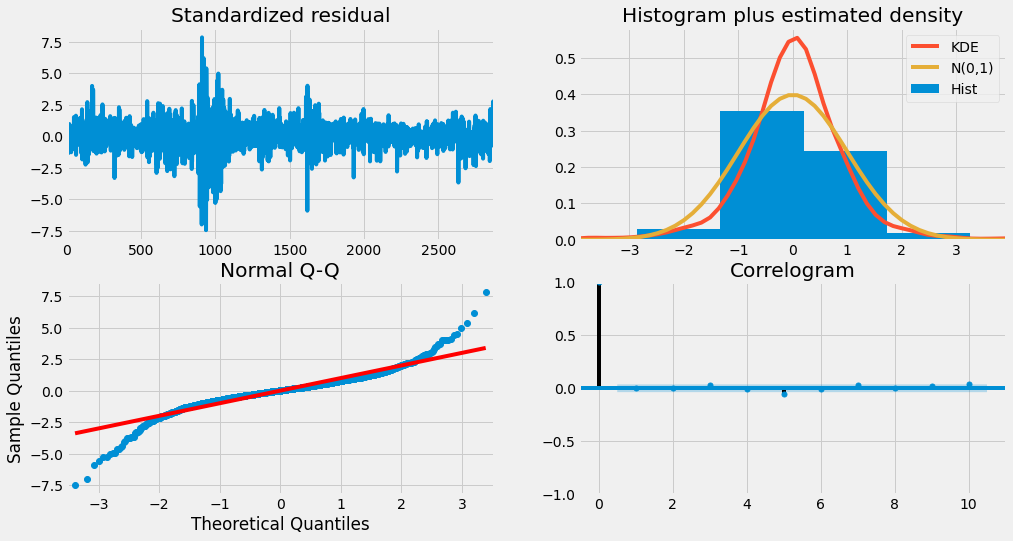

In [16]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?

 ✔**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

 ✔**Top Right:** The density plot suggest normal distribution with mean zero.

✔**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

✔**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not **autocorrelated**. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be **a good fit**. Let’s start forecasting the stock prices.

Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 2 respectively.**

### **Modeling**

Building a model

In [17]:
import statsmodels.api as sm

In [78]:
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2877
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8267.798
Date:                Mon, 02 Jan 2023   AIC                         -16527.597
Time:                        17:22:09   BIC                         -16503.740
Sample:                             0   HQIC                        -16518.997
                               - 2877                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8973      0.036     24.798      0.000       0.826       0.968
ma.L1         -1.0130      0.039    -25.731      0.000      -1.090      -0.936
ma.L2          0.0826      0.014      5.842      0.0

**Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.**

In [ ]:
# Forecast
fc = fitted.forecast(321, alpha=0.05)  # 95% conf

In [37]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.05047164043356361
MAE: 0.20771790107058907
RMSE: 0.22465894247406135
